In [590]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from catboost import CatBoostRegressor
from catboost import Pool

# pd.options.display.max_columns = None

In [562]:
request = requests.get("https://justjoin.it/api/offers")
data = request.json()
df = pd.DataFrame.from_dict(data)

In [563]:
contract_type_column = lambda data: data[0]["type"]
salary_from_type_column = lambda data: data[0]["salary"]["from"] if data[0]["salary"] is not None else data[0]["salary"]
salary_to_type_column = lambda data: data[0]["salary"]["to"] if data[0]["salary"] is not None else data[0]["salary"]
currency_type_column = lambda data: data[0]["salary"]["currency"] if data[0]["salary"] is not None else data[0]["salary"]


df["contract_type"] = df["employment_types"].apply(contract_type_column)
df["salary_from"] = df["employment_types"].apply(salary_from_type_column)
df["salary_to"] = df["employment_types"].apply(salary_to_type_column)
df["curr"] = df["employment_types"].apply(currency_type_column)

df.drop(columns=["employment_types"], inplace=True)

In [564]:
df["skill_types"] = df["skills"].apply(lambda x: [i["name"] for i in x])
df["skill_values"] = df["skills"].apply(lambda x: [i["level"] for i in x])

df.drop(columns=["skills"], inplace=True)

In [565]:
df.head(3)

,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,company_size,experience_level,latitude,longitude,published_at,remote_interview,open_to_hire_ukrainians,id,company_logo_url,remote,contract_type,salary_from,salary_to,curr,skill_types,skill_values
0,"Sr Software Engineer, React Components",Centrum,Bydgoszcz,PL,"Centrum, Bydgoszcz",javascript,remote,PubNub,http://www.pubnub.com,100 - 150,senior,53.1216327,17.9994868,2022-03-27T18:00:16.191Z,True,False,pubnub-sr-software-engineer-react-components-b...,https://bucket.justjoin.it/offers/company_logo...,True,b2b,21000.0,27000.0,pln,"[Teamwork, TypeScript, JavaScript]","[3, 4, 4]"
1,Java Developer for Live Odds Tribe,Hrubieszowska 2,Warszawa,PL,"Hrubieszowska 2, Warszawa",java,partly_remote,Sportradar,https://sportradar.com,500+,senior,52.2303362,20.980361,2022-03-27T18:00:16.191Z,False,False,sportradar-java-developer-for-live-odds-tribe,https://bucket.justjoin.it/offers/company_logo...,False,permanent,15000.0,22000.0,pln,"[Clean Code, Docker, Java]","[4, 5, 5]"
2,Scrum Master,Centrum,Warszawa,PL,"Centrum, Warszawa",pm,partly_remote,Nokia,https://en.nokiakrakow.pl/,3000+,mid,52.2302091,21.0113922,2022-03-27T18:00:16.191Z,True,True,nokia-scrum-master-a9868450-3930-4423-96e3-d1b...,https://bucket.justjoin.it/offers/company_logo...,False,permanent,NaN,NaN,None,"[Agile, Scrum]","[3, 3]"


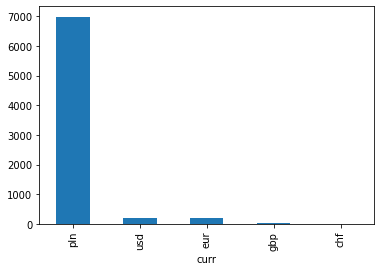

In [566]:
df.groupby("curr").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

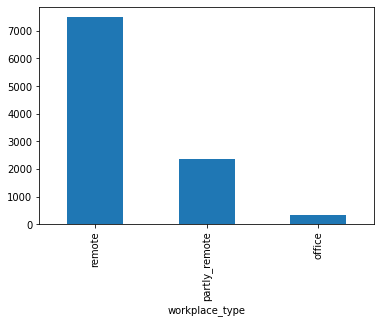

In [567]:
df.groupby("workplace_type").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

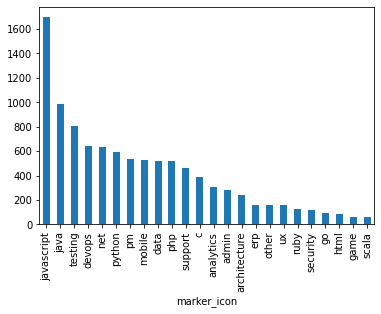

In [568]:
df.groupby("marker_icon").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

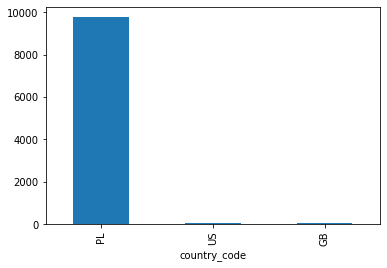

In [569]:
df.groupby("country_code").count()["id"].sort_values(ascending=False).head(3).plot(kind="bar")
plt.show()

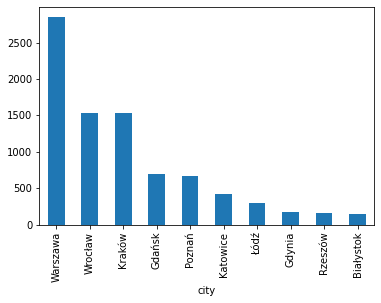

In [570]:
df.groupby("city").count()["id"].sort_values(ascending=False).head(10).plot(kind="bar")
plt.show()

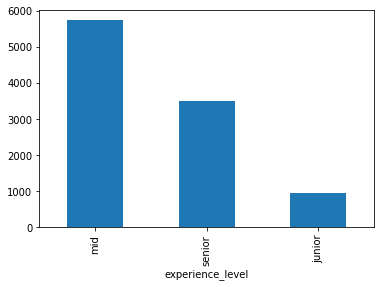

In [571]:
df.groupby("experience_level").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()


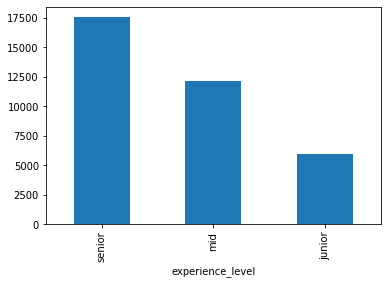

In [572]:
df.groupby("experience_level").mean()["salary_from"].sort_values(ascending=False).plot(kind="bar")
plt.show()

In [573]:
df.to_csv("salaries.csv", index=False)

In [574]:
df = df[df["country_code"] == "PL"]


In [575]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9762 entries, 0 to 10157
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    9762 non-null   object 
 1   street                   9760 non-null   object 
 2   city                     9762 non-null   object 
 3   country_code             9762 non-null   object 
 4   address_text             9762 non-null   object 
 5   marker_icon              9762 non-null   object 
 6   workplace_type           9762 non-null   object 
 7   company_name             9762 non-null   object 
 8   company_url              9762 non-null   object 
 9   company_size             9762 non-null   object 
 10  experience_level         9762 non-null   object 
 11  latitude                 9762 non-null   object 
 12  longitude                9762 non-null   object 
 13  published_at             9762 non-null   object 
 14  remote_interview       

In [576]:
df.drop(['title',
        #  'city',
         'street',
         'country_code',
         'address_text',
         'company_name',
         'company_url',
         'company_size',
         'latitude',
         'longitude',
         'published_at',
         'open_to_hire_ukrainians',
         'id',
         'company_logo_url',
         'skill_types',
         'skill_values'
         ], axis=1, inplace=True)

In [577]:
df = df.dropna()

In [578]:
df['remote_interview'] = df['remote_interview'].astype('int')
df['remote'] = df['remote'].astype('int')
df = df[df["curr"] == "pln"]
df.drop(["curr"], axis=1, inplace=True)

In [579]:
le = LabelEncoder()
le_columns = ["experience_level", "workplace_type", "contract_type"]
df[le_columns] = df[le_columns].apply(lambda x: le.fit_transform(x))

In [580]:
#create new column salary_mean and calculate mean salary from salary_from and salary_to
df["salary_mean"] = df.apply(lambda x: (x["salary_from"] + x["salary_to"]) / 2, axis=1)

In [581]:
df.drop(['salary_from',
         'salary_to'
         ], axis=1, inplace=True)

In [582]:
df.head()

,city,marker_icon,workplace_type,experience_level,remote_interview,remote,contract_type,salary_mean
0,Bydgoszcz,javascript,2,2,1,1,0,24000.0
1,Warszawa,java,1,2,0,0,2,18500.0
3,Gdynia,data,2,1,1,1,0,10500.0
4,Warszawa,java,1,2,0,0,0,34000.0
5,Bydgoszcz,c,2,2,1,1,0,24000.0


In [583]:
df = pd.get_dummies(df, columns=["marker_icon", "city"])

features_object = df.select_dtypes(include="object").columns
df = pd.get_dummies(df, columns=features_object)

In [584]:
df.head()

,workplace_type,experience_level,remote_interview,remote,contract_type,salary_mean,marker_icon_admin,marker_icon_analytics,marker_icon_architecture,marker_icon_c,marker_icon_data,marker_icon_devops,marker_icon_erp,marker_icon_game,marker_icon_go,marker_icon_html,marker_icon_java,marker_icon_javascript,marker_icon_mobile,marker_icon_net,marker_icon_other,marker_icon_php,marker_icon_pm,marker_icon_python,marker_icon_ruby,marker_icon_scala,marker_icon_security,marker_icon_support,marker_icon_testing,marker_icon_ux,city_Białe Błota,city_Białystok,city_Bielany Wrocławskie,city_Bielsko-Biala,city_Bielsko-Biała,city_Bydgoszcz,city_Chorzów,city_Czyżemin,city_Częstochowa,city_Dobrodzień,city_Dąbrowa Górnicza,city_Gdańsk,city_Gdańsk,city_Gdynia,city_Gliwice,city_Godzikowice,city_Gorzów Wielkopolski,city_Grodzisk Mazowiecki,city_Głuchowo,city_Jelcz-Laskowice,city_Kalisz,city_Katowice,city_Kielce,city_Koszalin,city_Kotlarka,city_Kraków,city_Kutno,city_Leszno,city_Lublin,city_Mysłowice,city_Niepruszewo,city_Nowy Konik,city_Olsztyn,city_Opole,city_Ostrów Wielkopolski,city_Piaseczno,city_Poland,"city_Poland, remote",city_Polska,city_Poznań,city_Pruszków,city_Płock,city_Robakowo,city_Rybnik,city_Rzeszow,city_Rzeszów,city_Siedlce,city_Sieradz,city_Sopot,city_Sosnowiec,city_Szczecin,city_Słupsk,city_Tajęcina,city_Tarnowskie Góry,city_Tarnów,city_Torun,city_Toruń,city_Trójmiasto,city_Tychy,city_Warsaw,city_Warszawa,city_Warszwa,city_Wałbrzych,city_Wieliczka,city_Wrocław,city_Wysogotowo,city_Włocławek,city_Zabierzów,city_Zabrze,city_Zielona Gora,city_Zielona Góra,city_Łódź,city_Świdnica
0,2,2,1,1,0,24000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,0,0,2,18500.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2,1,1,1,0,10500.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,0,0,0,34000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,2,2,1,1,0,24000.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [585]:
X = df.drop(["salary_mean"], axis=1)
y = df["salary_mean"]

In [586]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(X_test.shape)

(5170, 102)
(1724, 102)


In [594]:
train_dataset = Pool(X_train, y_train)
test_dataset = Pool(X_test, y_test)

catboost_model = CatBoostRegressor(iterations=1000,
                                    learning_rate=0.1,
                                    depth=6,
                                    loss_function='RMSE',
                                    eval_metric='RMSE',
                                    random_seed=42,
                                    silent=True)
 
catboost_model.fit(train_dataset, eval_set=test_dataset)

cv_model = cross_val_score(
    catboost_model, X_train, y_train, cv=10, scoring="neg_mean_absolute_error"
)

y_preds = catboost_model.predict(X_test)
cv_model_mean = np.mean(cv_model)

In [595]:
print("Cross val score:", cv_model_mean)
print("MAE: ", model_evaluate(y_test, y_preds))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_preds)))
print(f"R-Squared: {r2_score(y_test, y_preds)}")

Cross val score: -3161.6423870196804
MAE:  3147.861638720038
RMSE:  4190.375487048602
R-Squared: 0.5635178008603563
